# Question 2 : Faster RCNN Based Model Object Detection


## Task :

<ul>
<li>Train model Faster RCNN for object detection in dataset Pascal VOC </li>
</ul>


In [21]:
gpu = True

if gpu == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Model Description

**Convolutional Layer:**
Convolutional layers are fundamental building blocks in convolutional neural networks (CNNs). They perform convolutions on input images using learnable filters (kernels), which helps in capturing hierarchical features of the input data. In Faster R-CNN, convolutional layers are used to extract feature maps from the input images.

**RPN (Region Proposal Network):**
The RPN is a part of the Faster R-CNN architecture responsible for proposing candidate object regions within the feature map generated by the convolutional layers. It operates by sliding a small network (often a few convolutional layers) over the feature map, predicting whether there is an object or not, and suggesting bounding box proposals.

**ROI (Region of Interest) Pooling:**
After obtaining region proposals from the RPN, the ROI pooling layer is used to extract fixed-size feature maps from each proposed region. Since the proposed regions may have different sizes, ROI pooling ensures that they are all resized to a consistent size. This is important for feeding the proposals into subsequent layers for further processing.

**Classification Layer:**
The classification layer is responsible for classifying the content within each region proposal. In Faster R-CNN, it typically involves two sub-tasks: object classification (determining the class of the object within the proposal) and bounding box regression (refining the coordinates of the bounding box). This layer is often connected to the ROI-pooled feature maps and produces final class scores and bounding box coordinates for each proposed region.

## Import Libraries

In [47]:
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import math
import sys
import time
import torch
import os
from scipy.io import loadmat
from google.colab import drive
import random
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import warnings

warnings.filterwarnings('ignore')

In [12]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Gathering dataset folder

In [15]:
source_path = '/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/'
destination_path = '/content/dataset'
!cp -r "$source_path" "$destination_path"


## Preprocess

Show Images ( 5 random selected ) + labels

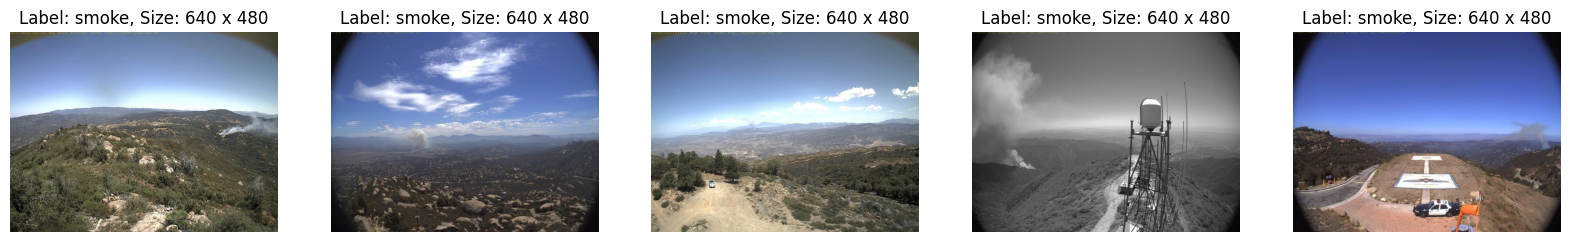

In [32]:


# Paths
xml_folder = '/content/dataset/train'
image_folder = '/content/dataset/train'


def extract_info(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    label = root.find('.//name').text

    size_elem = root.find('.//size')
    width = int(size_elem.find('width').text)
    height = int(size_elem.find('height').text)

    return label, width, height

xml_files = [f for f in os.listdir(xml_folder) if f.endswith('.xml')]

import random
random.seed(42)
selected_files = random.sample(xml_files, 5)

plt.figure(figsize=(20, 3))

for i, xml_file in enumerate(selected_files):
    xml_path = os.path.join(xml_folder, xml_file)

    label, width, height = extract_info(xml_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(Image.open(os.path.join(image_folder, xml_file.replace('.xml', '.jpg'))))
    plt.title(f"Label: {label}, Size: {width} x {height}")
    plt.axis('off')

plt.show()


get number of classes

In [33]:
def extract_labels(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # Extract label
    label = root.find('.//name').text
    return label

In [34]:
xml_files = [f for f in os.listdir(xml_folder) if f.endswith('.xml')]
unique_labels = set()

for xml_file in xml_files:
    xml_path = os.path.join(xml_folder, xml_file)

    # Extract label
    label = extract_labels(xml_path)

    # Add label to set
    unique_labels.add(label)

# Number of unique labels
num_unique_labels = len(unique_labels)

print(f"Number of unique labels: {num_unique_labels}")
print("Unique Labels:", unique_labels)

Number of unique labels: 1
Unique Labels: {'smoke'}


resize images

In [36]:
desired_size = (800, 800)


In [40]:
folders = ['/content/dataset/train', '/content/dataset/valid', '/content/dataset/test']


In [42]:
def resize_image_and_xml(image_path, xml_path):
    img = Image.open(image_path)
    img = img.resize(desired_size)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    size_elem = root.find('.//size')
    size_elem.find('width').text = str(desired_size[0])
    size_elem.find('height').text = str(desired_size[1])

    tree.write(xml_path)

    img.save(image_path)
    print(f"Resized image shape: {img.size}")

In [ ]:
for folder in folders:
    # Get list of image files
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Loop through each image file
    for image_file in image_files:
        image_path = os.path.join(folder, image_file)
        xml_path = os.path.join(folder, image_file.replace('.jpg', '.xml').replace('.jpeg', '.xml').replace('.png', '.xml'))

        # Resize image and update XML
        resize_image_and_xml(image_path, xml_path)

print("Images and XML files have been resized and updated.")

##Model & Dataset

In [16]:
model = fasterrcnn_resnet50_fpn(pretrained=True)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:04<00:00, 38.3MB/s]


Model modifications based on paper

In [52]:
import torch.nn as nn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [49]:
class CustomBackbone(nn.Module):
    def __init__(self):
        super(CustomBackbone, self).__init__()
        self.conv_layers = self._make_conv_layers()
        self.pool_layers = self._make_pool_layers()

    def _make_conv_layers(self):
        return nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True)

        )

    def _make_pool_layers(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.pool_layers(x)
        return x


In [55]:
import torchvision.ops as ops

class ProposalLayer(nn.Module):
    def __init__(self, pre_nms_topN=6000, post_nms_topN=300, nms_thresh=0.7):
        super(ProposalLayer, self).__init__()
        self.pre_nms_topN = pre_nms_topN
        self.post_nms_topN = post_nms_topN
        self.nms_thresh = nms_thresh

    def forward(self, rpn_locs, rpn_scores, anchors, image_size):
        # Generate proposals based on RPN predicted offset and positive bounding box
        proposals = ops.box_decode(anchors, rpn_locs)

        # Process bbox exceeding image boundary
        proposals[:, 0::4] = torch.clamp(proposals[:, 0::4], 0, image_size[1])
        proposals[:, 1::4] = torch.clamp(proposals[:, 1::4], 0, image_size[0])
        proposals[:, 2::4] = torch.clamp(proposals[:, 2::4], 0, image_size[1])
        proposals[:, 3::4] = torch.clamp(proposals[:, 3::4], 0, image_size[0])

        # Remove bboxes less than the threshold
        keep = (proposals[:, 2] > proposals[:, 0]) & (proposals[:, 3] > proposals[:, 1])
        proposals = proposals[keep]

        # Sort all (proposal, score) pairs from high to low according to the value of the score
        _, order = torch.sort(rpn_scores, descending=True)
        proposals = proposals[order]

        # Take the first pre_nms_topN values
        proposals = proposals[:self.pre_nms_topN]

        # Perform NMS on the remaining positive proposals
        keep = ops.nms(proposals[:, :4], proposals[:, 4], self.nms_thresh)

        # Take the top post_nms_topN values after NMS
        keep = keep[:self.post_nms_topN]
        proposals = proposals[keep]

        return proposals


In [57]:
class CustomRoIPooling(nn.Module):
    def __init__(self, pooled_height, pooled_width, spatial_scale):
        super(CustomRoIPooling, self).__init__()
        self.pooled_height = pooled_height
        self.pooled_width = pooled_width
        self.spatial_scale = spatial_scale

    def forward(self, feature_map, proposals):
        # Transform proposals to the feature map coordinates
        proposals[:, 0::4] /= self.spatial_scale
        proposals[:, 1::4] /= self.spatial_scale
        proposals[:, 2::4] /= self.spatial_scale
        proposals[:, 3::4] /= self.spatial_scale

        # Perform RoI pooling
        pooled_features = ops.roi_pool(feature_map, proposals, (self.pooled_height, self.pooled_width))

        return pooled_features



In [60]:
num_classes = len(unique_labels) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [61]:
custom_backbone = CustomBackbone()
proposal_layer = ProposalLayer()
roi_pooling_layer = CustomRoIPooling(pooled_height=7, pooled_width=7, spatial_scale=1/16)
num_classes = len(unique_labels) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## Train and fit model

In [99]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, xml_folder, image_folder, transform=None):
        self.xml_folder = xml_folder
        self.image_folder = image_folder
        self.transform = transform
        self.image_list = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
        self.unique_labels = list(unique_labels)  # Convert set to list

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        xml_path = os.path.join(self.xml_folder, img_name.replace('.jpg', '.xml'))

        img_path = os.path.join(self.image_folder, img_name)
        img = Image.open(img_path).convert("RGB")

        labels = self._parse_xml(xml_path, img.size)

        if self.transform:
            img = self.transform(img)

        # Convert labels to target format
        targets = {}
        targets['boxes'] = torch.tensor([label['bbox'] for label in labels], dtype=torch.float32)
        targets['labels'] = torch.tensor([self.unique_labels.index(label['label']) + 1 for label in labels], dtype=torch.int64)

        return img, targets

    def _parse_xml(self, xml_path, img_size):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        labels = []

        for obj in root.findall('.//object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            labels.append({
                'label': label,
                'bbox': [xmin, ymin, xmax, ymax]
            })

        return labels


In [96]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),

])

train_dataset = CustomDataset(xml_folder='/content/dataset/train', image_folder='/content/dataset/train', transform=transform)
valid_dataset = CustomDataset(xml_folder='/content/dataset/valid', image_folder='/content/dataset/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=2)


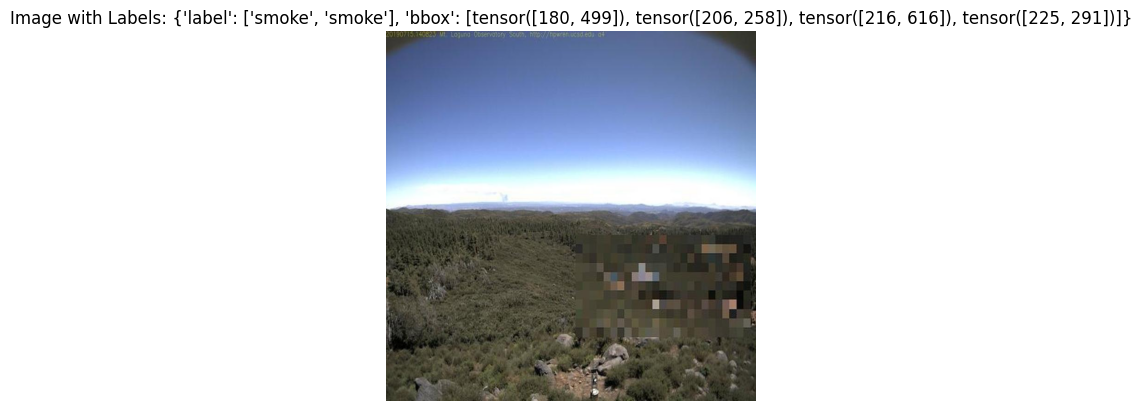

In [75]:
import matplotlib.pyplot as plt

# Get one batch from the training loader
for images, labels in train_loader:
    # Extract the first image and its labels
    image = images[0].permute(1, 2, 0).numpy()  # Change tensor shape for visualization
    label = labels[0]

    # Display the image
    plt.imshow(image)
    plt.title(f"Image with Labels: {label}")
    plt.axis('off')
    plt.show()

    # Break after displaying the first image
    break


In [93]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms.functional as TF

In [100]:
num_epochs = 1
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(num_epochs):
    # Training
    model.train()
    for images, targets in train_loader:
        images = list(TF.to_tensor(image).to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')


AttributeError: ignored